In [1]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99%|████████████████████████████████████████▋| 709M/714M [00:03<00:00, 219MB/s]
100%|█████████████████████████████████████████| 714M/714M [00:03<00:00, 218MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:

from PIL import Image


def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()


patient_id                        images  \
0  TCGA_CS_6668_20011025  TCGA_CS_6668_20011025_25.tif   
1  TCGA_CS_6668_20011025   TCGA_CS_6668_20011025_6.tif   
2  TCGA_CS_6668_20011025   TCGA_CS_6668_20011025_3.tif   
3  TCGA_CS_6668_20011025  TCGA_CS_6668_20011025_22.tif   
4  TCGA_CS_6668_20011025  TCGA_CS_6668_20011025_16.tif   

                               masks  diagnosis  
0  TCGA_CS_6668_20011025_25_mask.tif          0  
1   TCGA_CS_6668_20011025_6_mask.tif          0  
2   TCGA_CS_6668_20011025_3_mask.tif          0  
3  TCGA_CS_6668_20011025_22_mask.tif          0  
4  TCGA_CS_6668_20011025_16_mask.tif          1

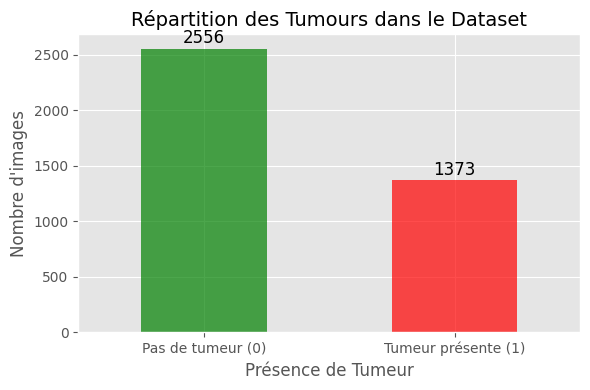

In [5]:
import matplotlib.pyplot as plt
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


In [6]:
pip install imageio


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


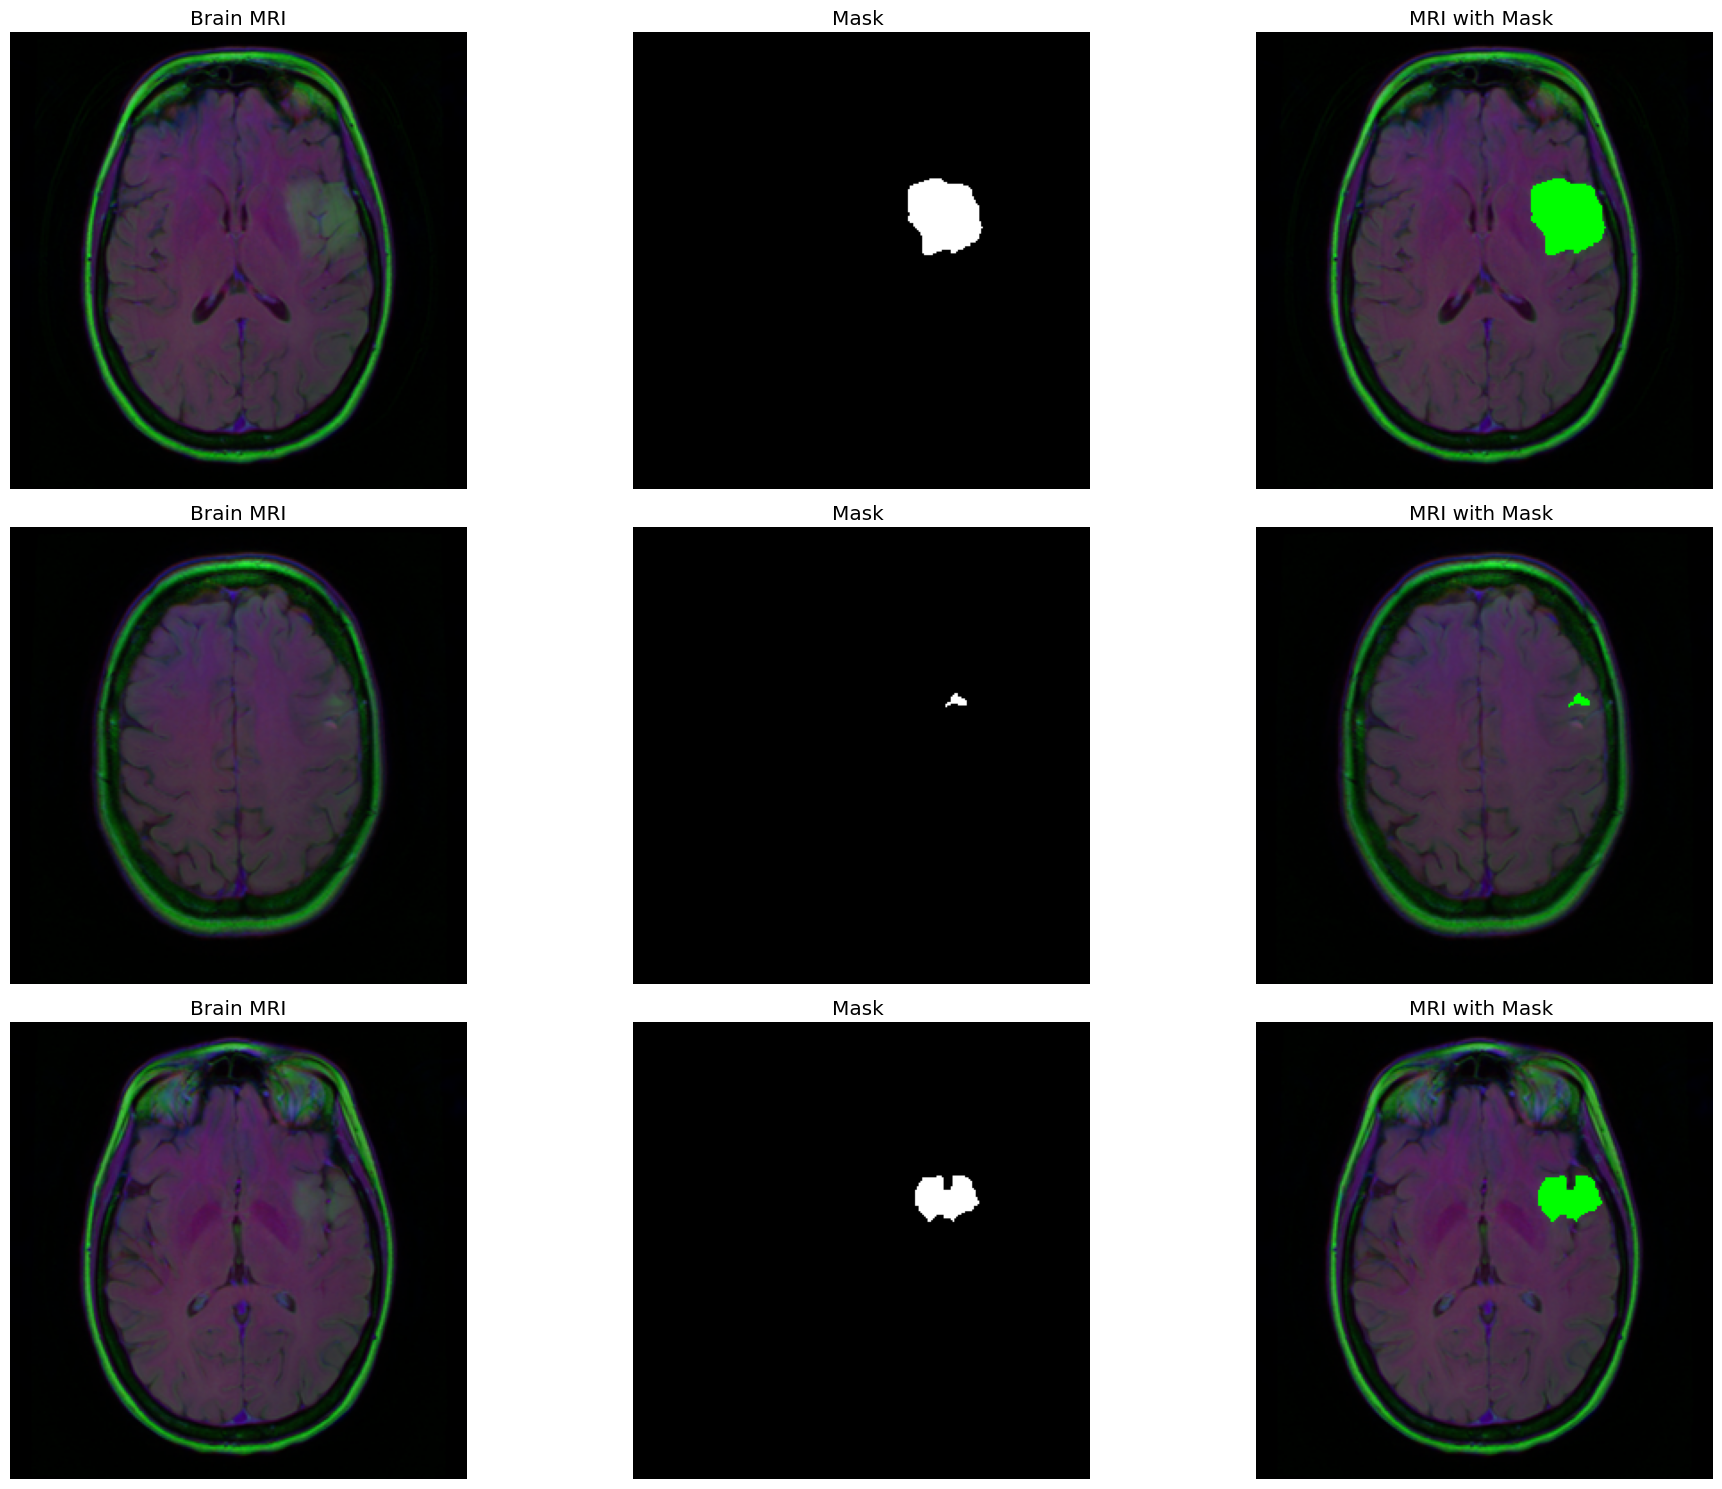

In [ ]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path) 
        mask = imread(mask_path) 

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)

train, val = train_test_split(train, test_size=0.1, random_state=25)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(test.head())


Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
1006  TCGA_CS_6188_20010812  TCGA_CS_6188_20010812_17.tif   
1217  TCGA_DU_6405_19851005  TCGA_DU_6405_19851005_55.tif   
3267  TCGA_DU_7304_19930325  TCGA_DU_7304_19930325_34.tif   
2033  TCGA_HT_7882_19970125  TCGA_HT_7882_19970125_22.tif   
3419  TCGA_DU_A5TU_19980312   TCGA_DU_A5TU_19980312_7.tif   

                                  masks  diagnosis  
1006  TCGA_CS_6188_20010812_17_mask.tif          1  
1217  TCGA_DU_6405_19851005_55_mask.tif          0  
3267  TCGA_DU_7304_19930325_34_mask.tif          0  
2033  TCGA_HT_7882_19970125_22_mask.tif          1  
3419   TCGA_DU_A5TU_19980312_7_mask.tif          0  


In [9]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from skimage import io
import pandas as pd

def adjust_data(img, mask):
    img = img / 255  
    mask = mask / 255  
    
    # Binarisation des masques : 1 pour la tumeur et 0 pour le reste
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images",  
        class_mode=None, 
        color_mode=image_color_mode,
        target_size=target_size, 
        batch_size=batch_size,
        save_to_dir=save_to_dir, 
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks",  
        class_mode=None,  
        color_mode=mask_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=mask_save_prefix,
        seed=seed
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask)  
        yield img, mask


In [ ]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train, 
    batch_size=32,         
    aug_dict=data_augmentation,  
    target_size=(256, 256)  
)
train.head()


patient_id  \
2754  TCGA_HT_7686_19950629   
1556  TCGA_DU_5872_19950223   
1620  TCGA_FG_6690_20020226   
1067  TCGA_DU_7309_19960831   
3616  TCGA_DU_5871_19941206   

                                                 images  \
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0

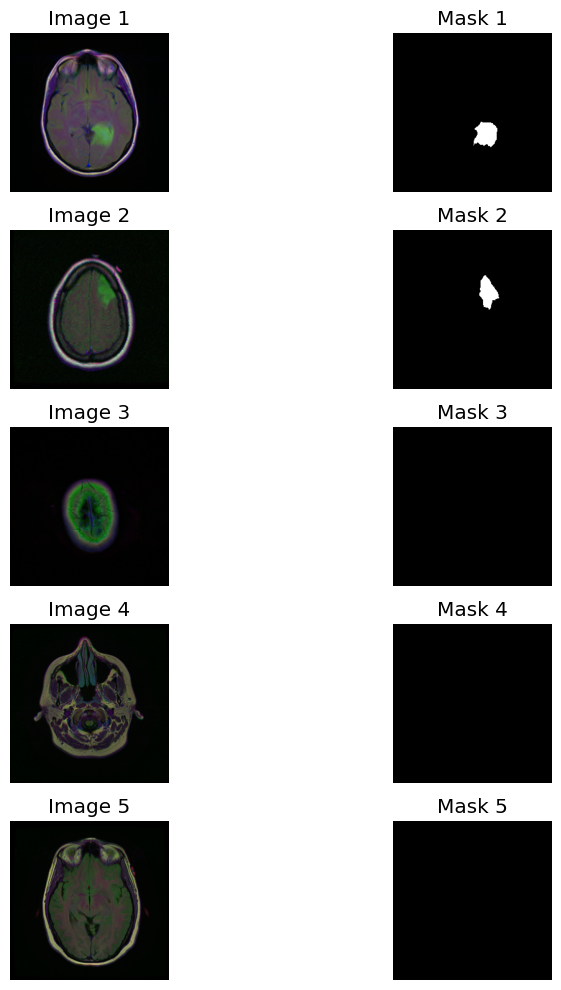

In [ ]:
import matplotlib.pyplot as plt
import cv2

num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images']  
    mask_path = train.iloc[i]['masks']   
    
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Convertir l'image pour l'affichage avec matplotlib (BGR -> RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val,  
    batch_size=32,       
    aug_dict={},         
    target_size=(256, 256)  
)


In [ ]:
# Tester avec un sous-ensemble plus petit du DataFrame pour voir si le générateur fonctionne correctement
small_train_df = train.sample(n=10)  
small_train_generator = data_generator(
    data_frame=small_train_df,  
    batch_size=2,      
    aug_dict=data_augmentation, 
    target_size=(256, 256)
)

sample_small_batch = next(small_train_generator)

print("Small batch image shape:", sample_small_batch[0].shape)
print("Small batch mask shape:", sample_small_batch[1].shape)


Found 10 validated image filenames.
Found 10 validated image filenames.
Small batch image shape: (2, 256, 256, 3)
Small batch mask shape: (2, 256, 256, 1)


In [15]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, UpSampling2D, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
def segnet():

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=img_input, outputs=x)
    
    return model

In [16]:
model=segnet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 256, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 128, 128, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 128, 128, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 64, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 64, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 64, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

In [17]:
# Métriques de performance
smooth = 0.00001

import tensorflow as tf

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score


def dice_coefficient(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    y_true = tf.cast(y_true_flat, tf.float32)
    y_pred = tf.cast(y_pred_flat, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(factor=0.1, min_lr=1e-5, verbose=1),
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')


In [19]:
from tensorflow.keras.metrics import Recall, Precision

learning_rate = 0.001
EPOCH = 120

model.compile(
    optimizer=Adam(learning_rate=learning_rate), 
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou, Recall(), Precision()]
)
# Calcul des steps par époque (en prenant le nombre d'images / taille du batch)
steps_per_epoch = int(len(train) / 32)
validation_steps = int(len(val) / 32)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_reduction, model_checkpoint]
)



82
9
Found 2651 validated image filenames.
Found 2651 validated image filenames.
Epoch 1/120


I0000 00:00:1732018454.303733     124 service.cc:145] XLA service 0x7a4564002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732018454.303817     124 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732018498.808581     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - dice_coefficient: 0.0334 - iou: 0.0170 - loss: 0.9666 - precision: 0.0321 - recall: 0.8536Found 295 validated image filenames.
Found 295 validated image filenames.

Epoch 1: val_dice_coefficient improved from -inf to 0.01754, saving model to unet_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 110s 628ms/step - dice_coefficient: 0.0334 - iou: 0.0170 - loss: 0.9666 - precision: 0.0323 - recall: 0.8545 - val_dice_coefficient: 0.0175 - val_iou: 0.0088 - val_loss: 0.9825 - val_precision: 0.0088 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/120
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - dice_coefficient: 0.0414 - iou: 0.0212 - loss: 0.9586 - precision: 0.0602 - recall: 0.9637
Epoch 2: val_dice_coefficient improved from 0.01754 to 0.02980, saving model to unet_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 647ms/step - dice_coefficient: 0.0414 - iou: 0.0212 - loss: 0.9586 - precision: 0.0602 - recall: 0.9637 - val_dice_coefficient: 0.0298 - val_iou: 0.015

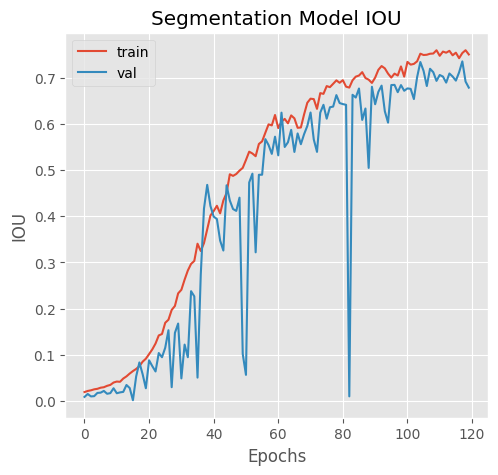

In [31]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou']);
plt.plot(history.history['val_iou']);
plt.title("Segmentation Model IOU");
plt.ylabel("IOU");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

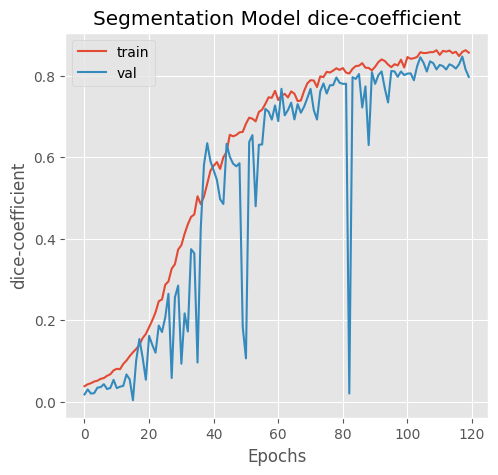

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dice-coefficient");
plt.ylabel("dice-coefficient");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

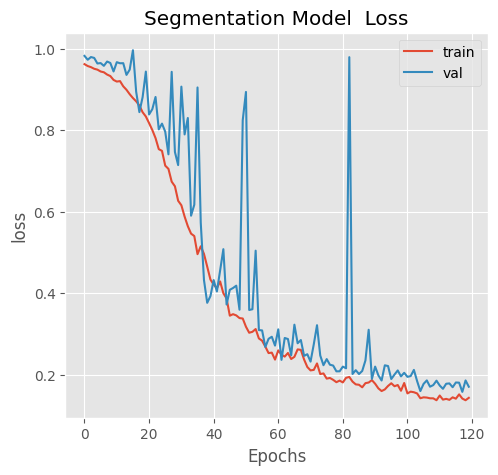

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model  Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

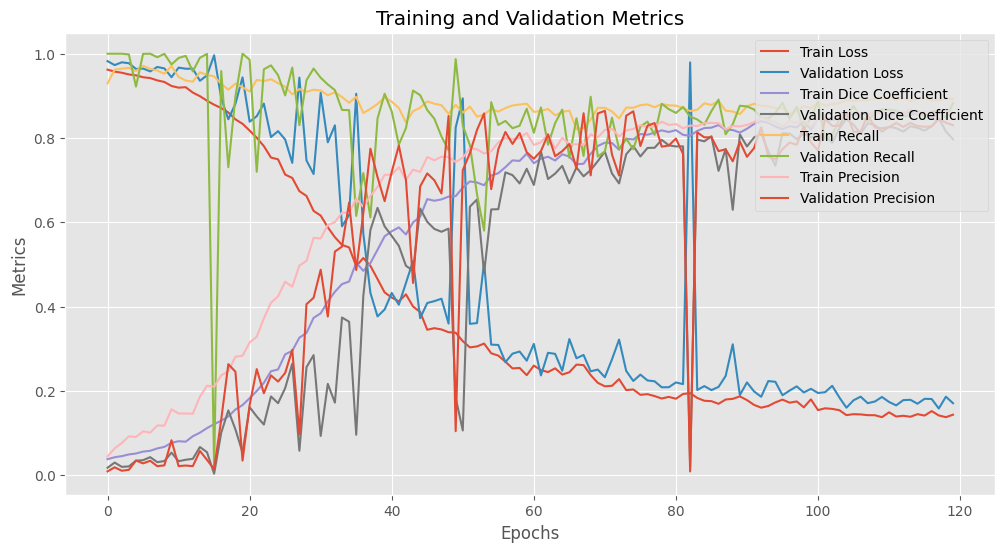

In [29]:
plt.figure(figsize=(12, 6))

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tracer Dice Coefficient
if 'dice_coefficient' in history.history:
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
if 'val_dice_coefficient' in history.history:
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')

# Tracer IOU Score
if 'iou_score' in history.history:
    plt.plot(history.history['iou_score'], label='Train IOU Score')
if 'val_iou_score' in history.history:
    plt.plot(history.history['val_iou_score'], label='Validation IOU Score')

# Tracer Recall
if 'recall' in history.history:
    plt.plot(history.history['recall'], label='Train Recall')
if 'val_recall' in history.history:
    plt.plot(history.history['val_recall'], label='Validation Recall')

# Tracer Precision
if 'precision' in history.history:
    plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')

plt.title("Training and Validation Metrics")
plt.ylabel("Metrics")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.grid(True)

plt.show()


In [24]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())


                 patient_id  \
1006  TCGA_CS_6188_20010812   
1217  TCGA_DU_6405_19851005   
3267  TCGA_DU_7304_19930325   
2033  TCGA_HT_7882_19970125   
3419  TCGA_DU_A5TU_19980312   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  


In [ ]:
import tensorflow as tf
import numpy as np



def combined_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",   
    class_mode=None, 
    color_mode="rgb", 
    target_size=(256, 256), 
    batch_size=32,
    seed=42,
    validate_filenames=False 
)

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test, 
    x_col="masks",  
    class_mode=None,  
    color_mode="grayscale",  
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32  

test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")


Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - dice_coefficient: 0.8529 - iou: 0.7444 - loss: 0.1471 - precision: 0.8465 - recall: 0.8841
Test Loss: 0.14010293781757355
Test Dice Coefficient: 0.8598971962928772
Test IoU: 0.7551928162574768
Test Recall: 0.8877014517784119
Test Precision: 0.8590553402900696


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


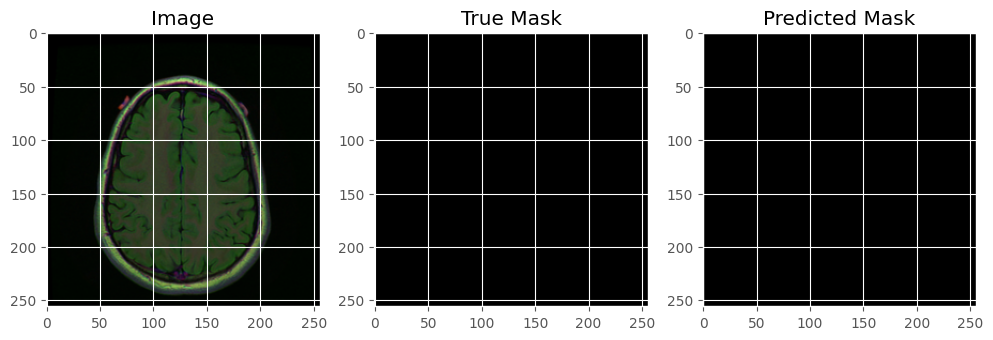

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


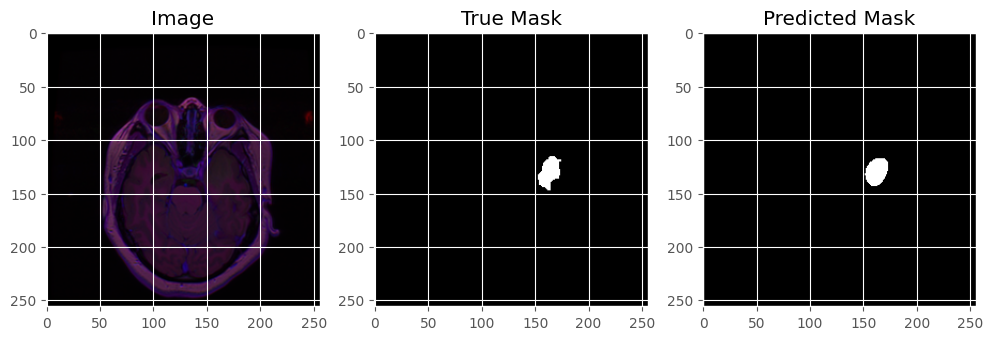

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


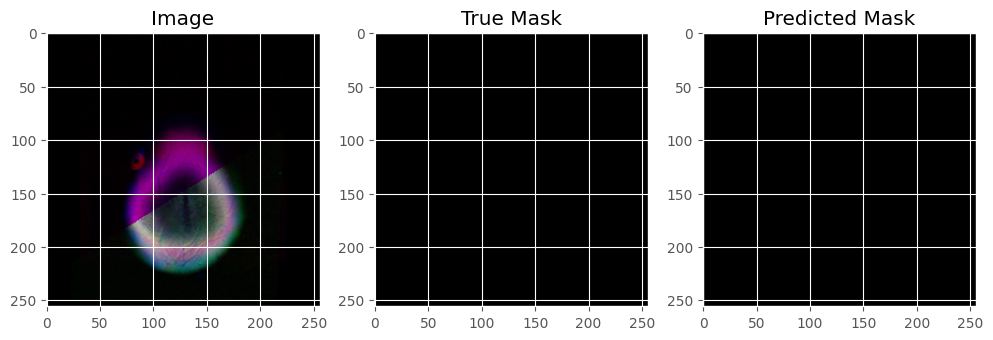

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


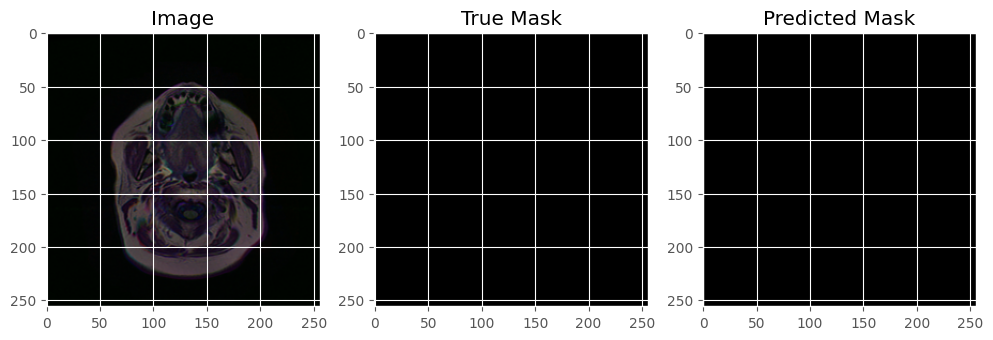

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


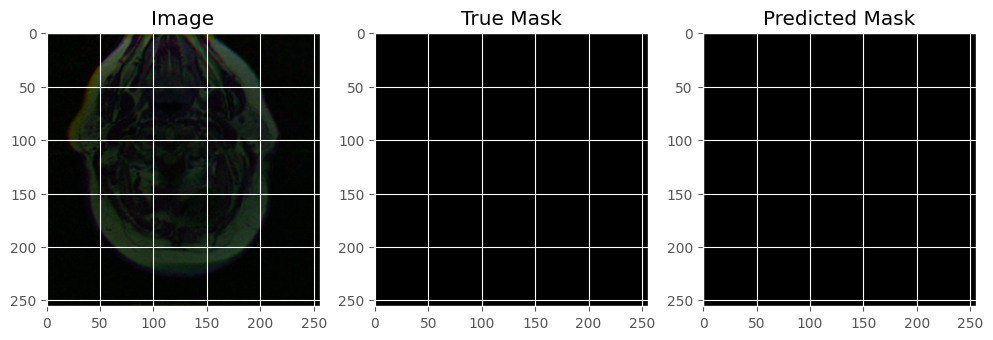

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


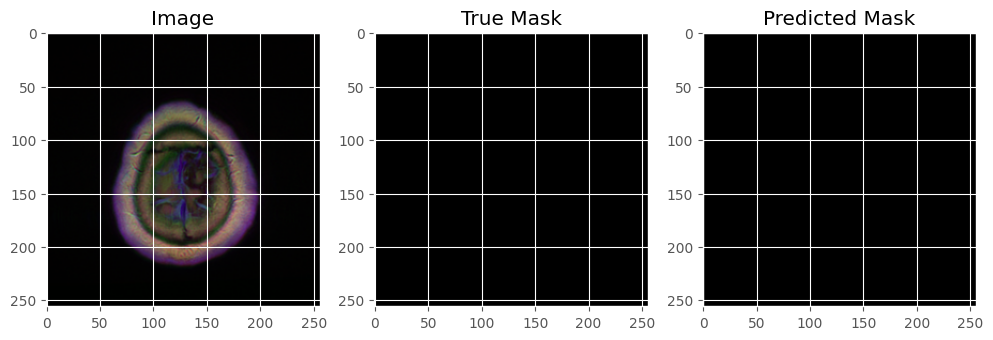

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


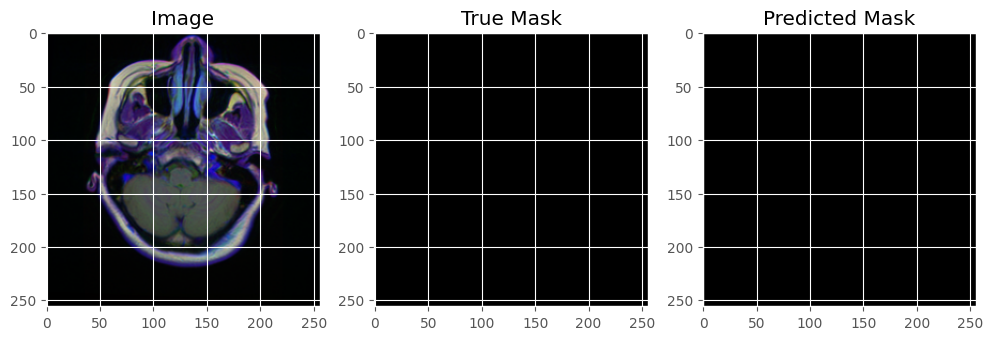

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


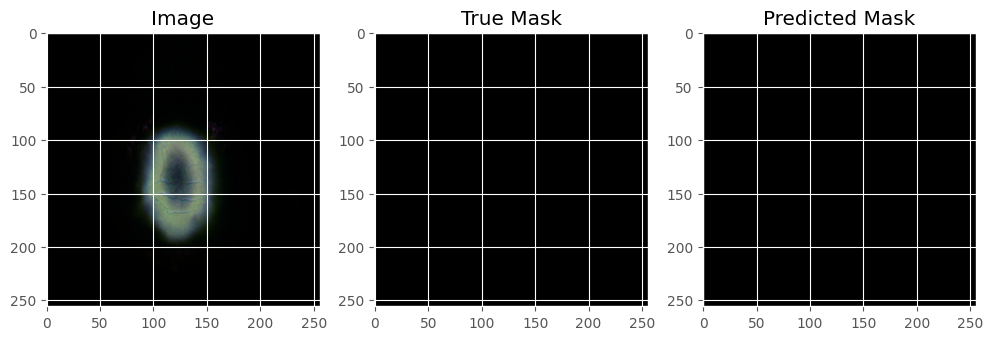

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


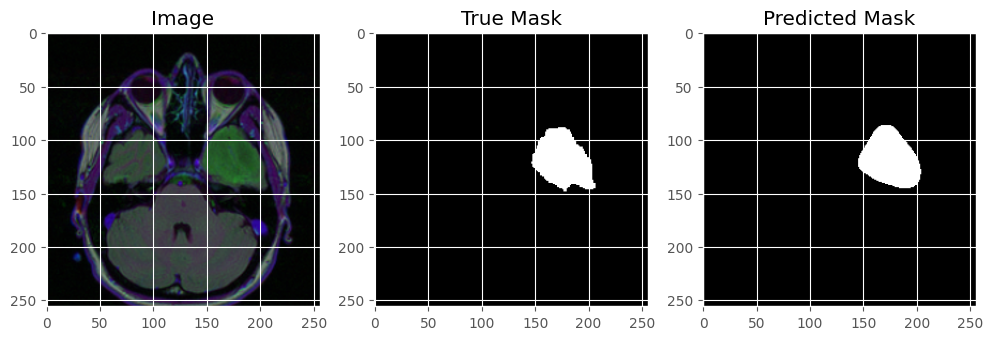

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


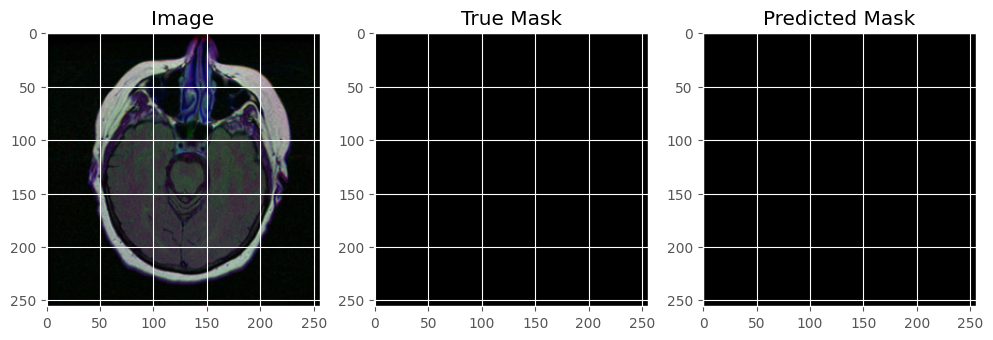

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    image, mask = next(test_generator)
    
    predicted_mask = model.predict(image)

    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    plt.figure(figsize=(12, 4))

    # Image d'entrée
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    # Masque prédit binarisé
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


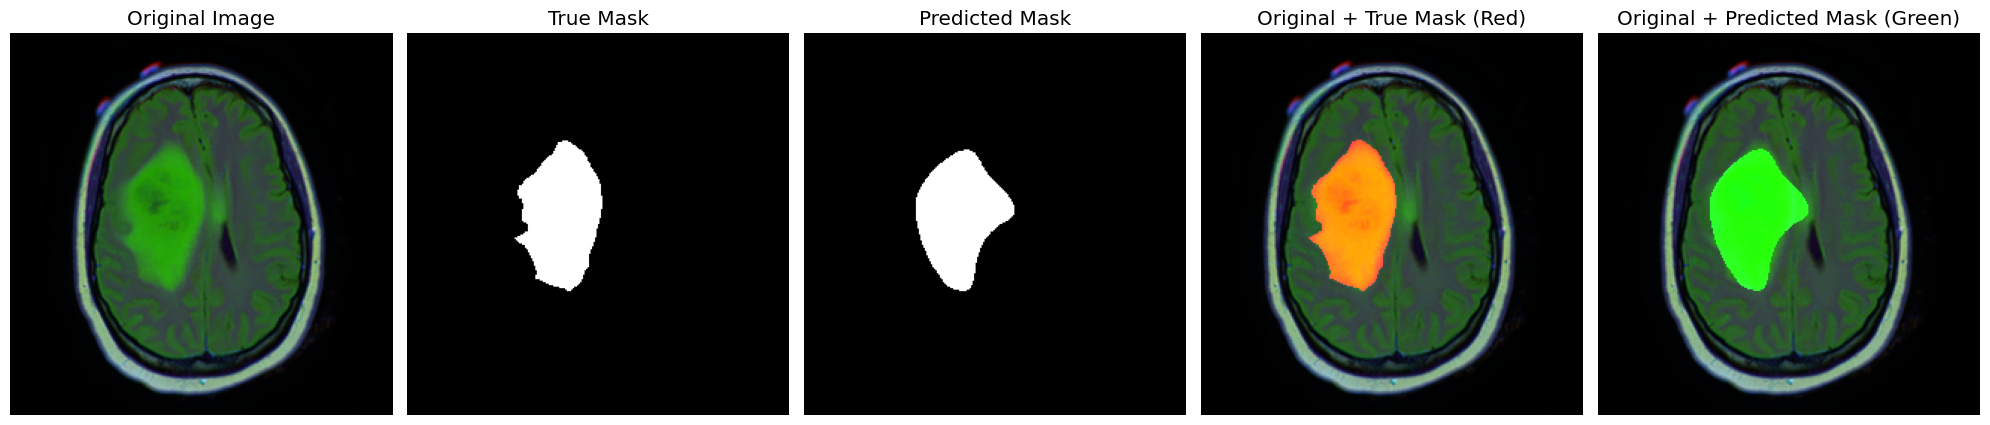

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


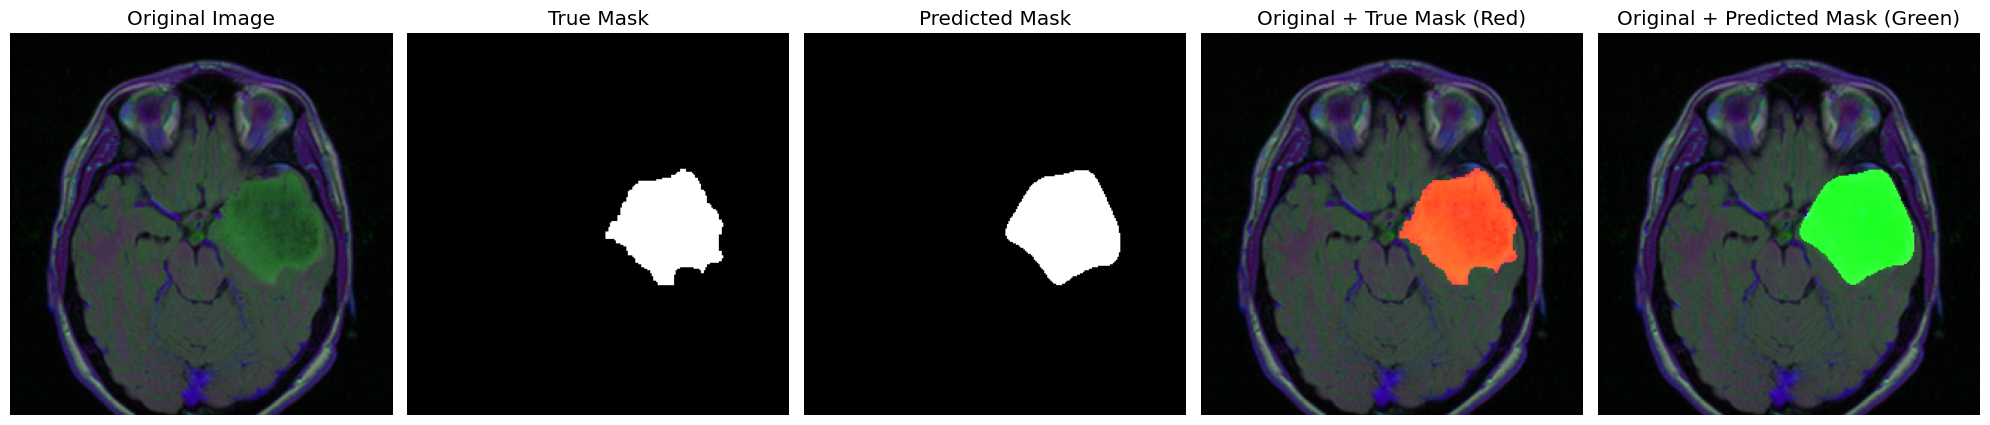

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


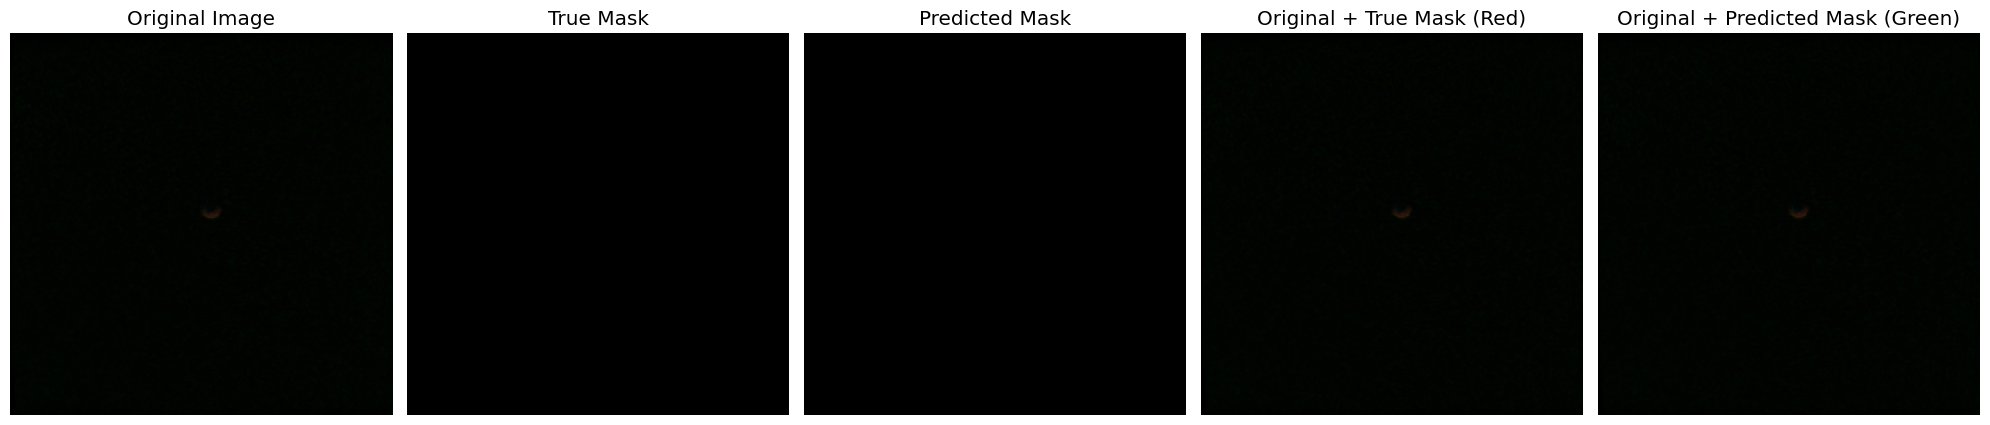

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


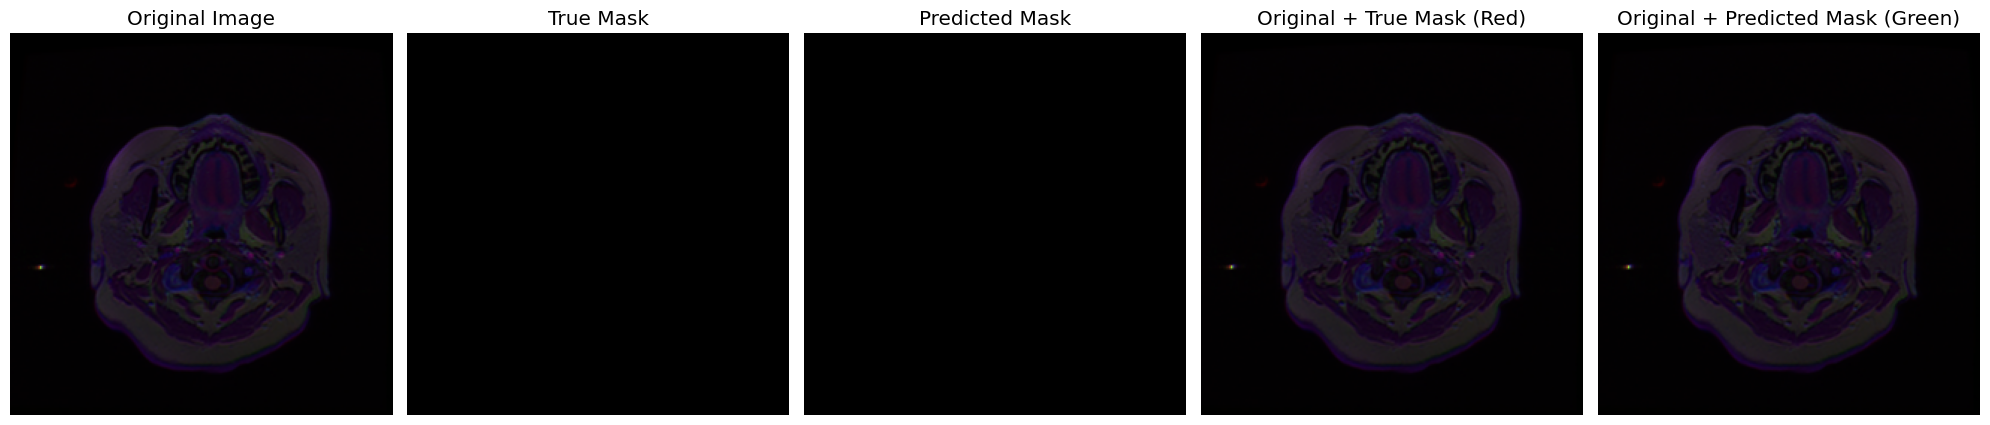

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


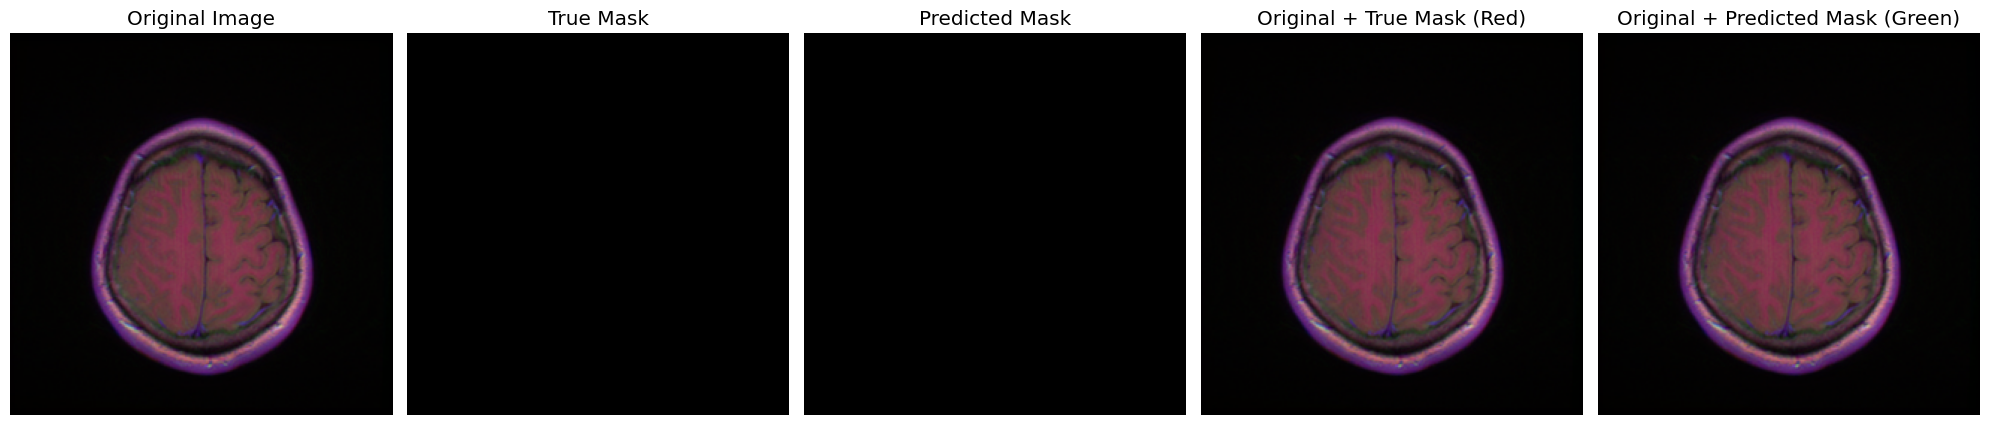

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


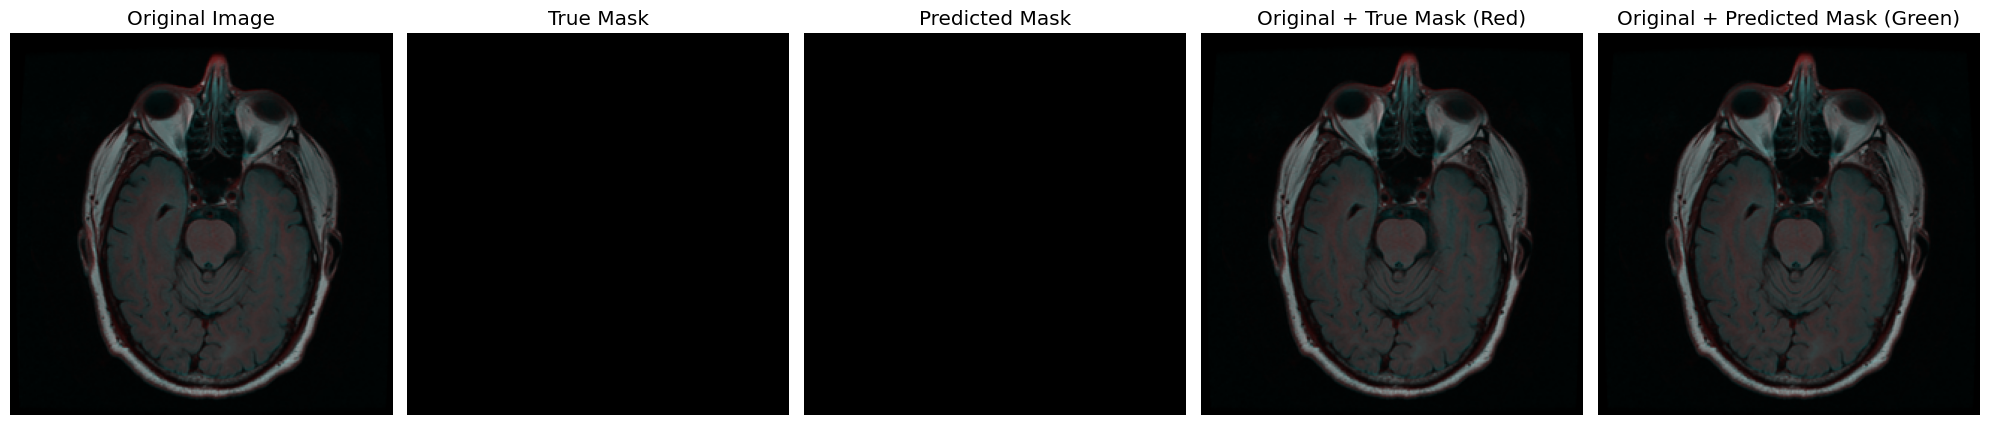

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


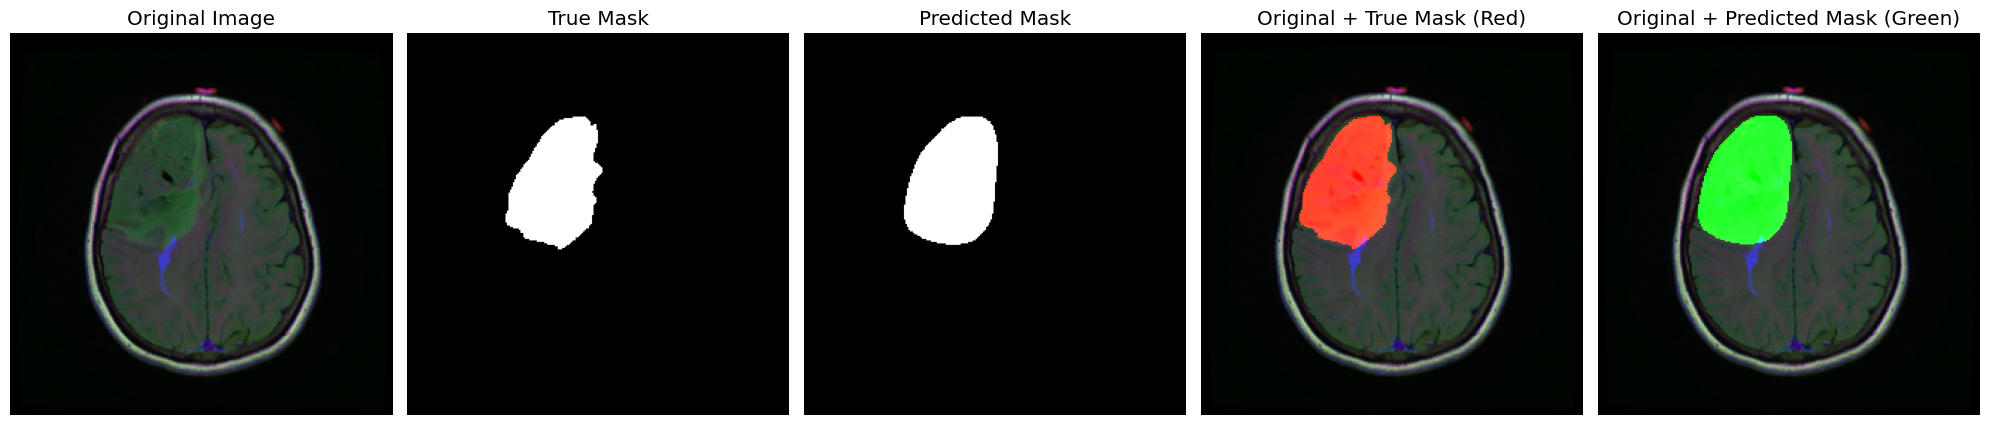

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


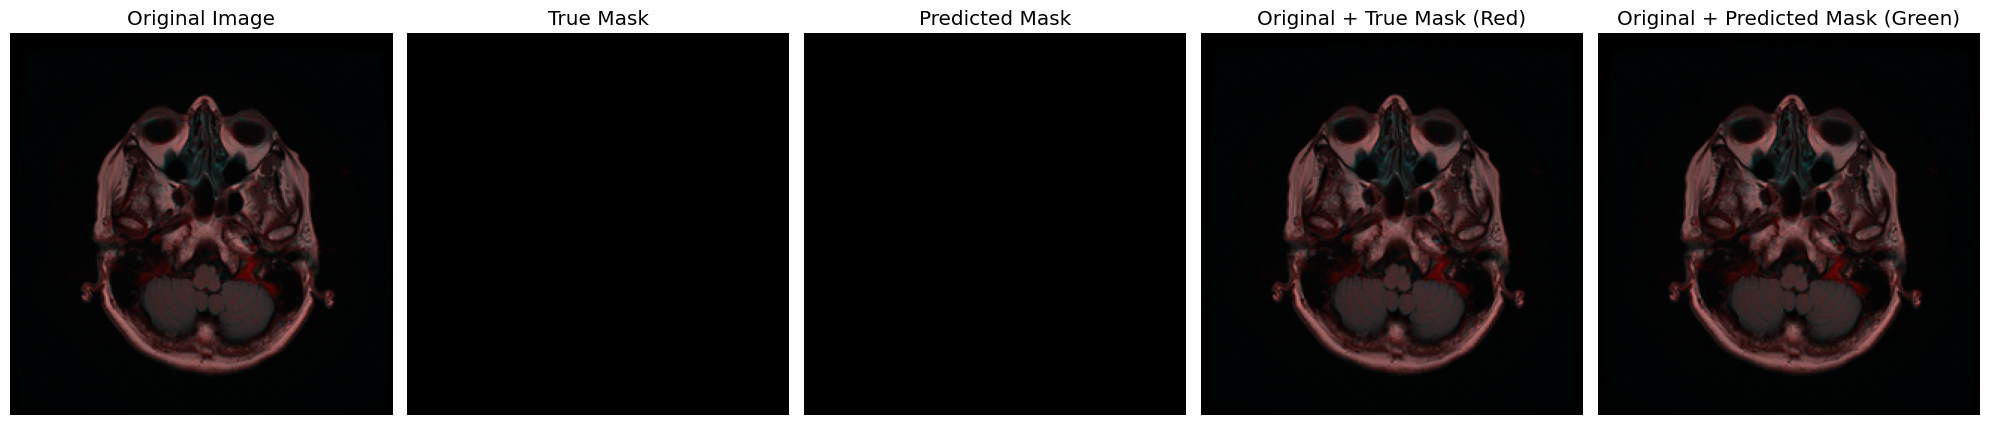

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


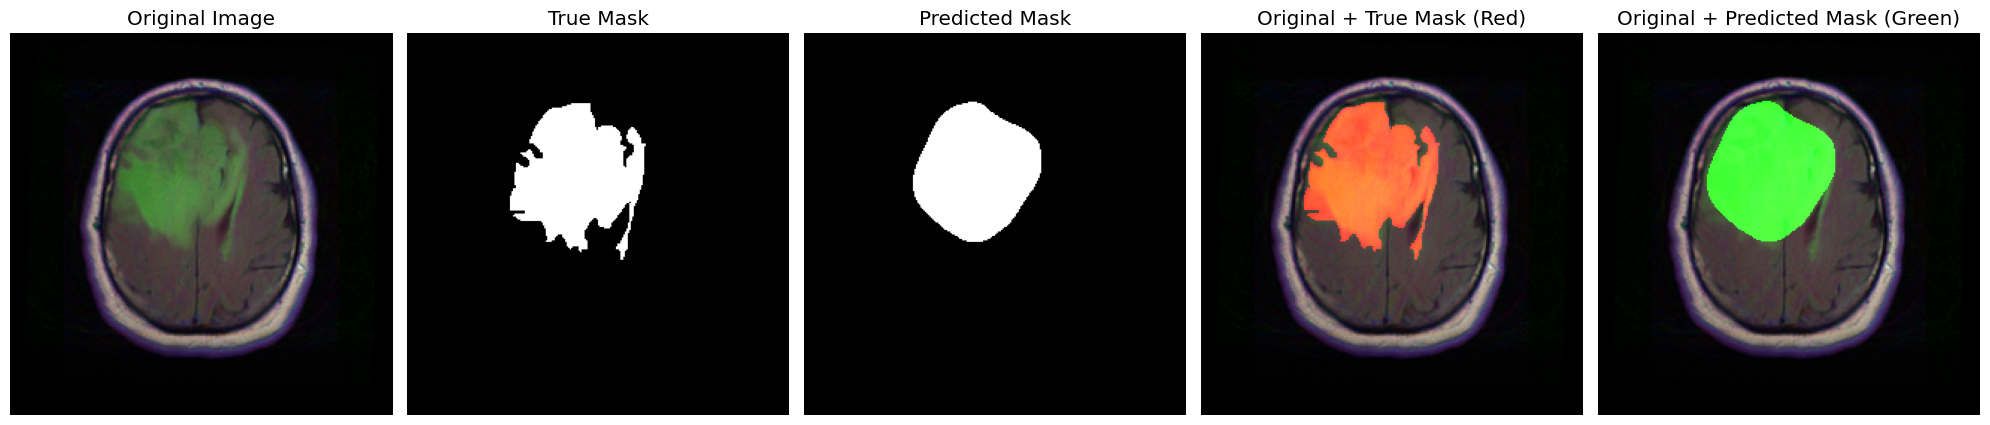

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


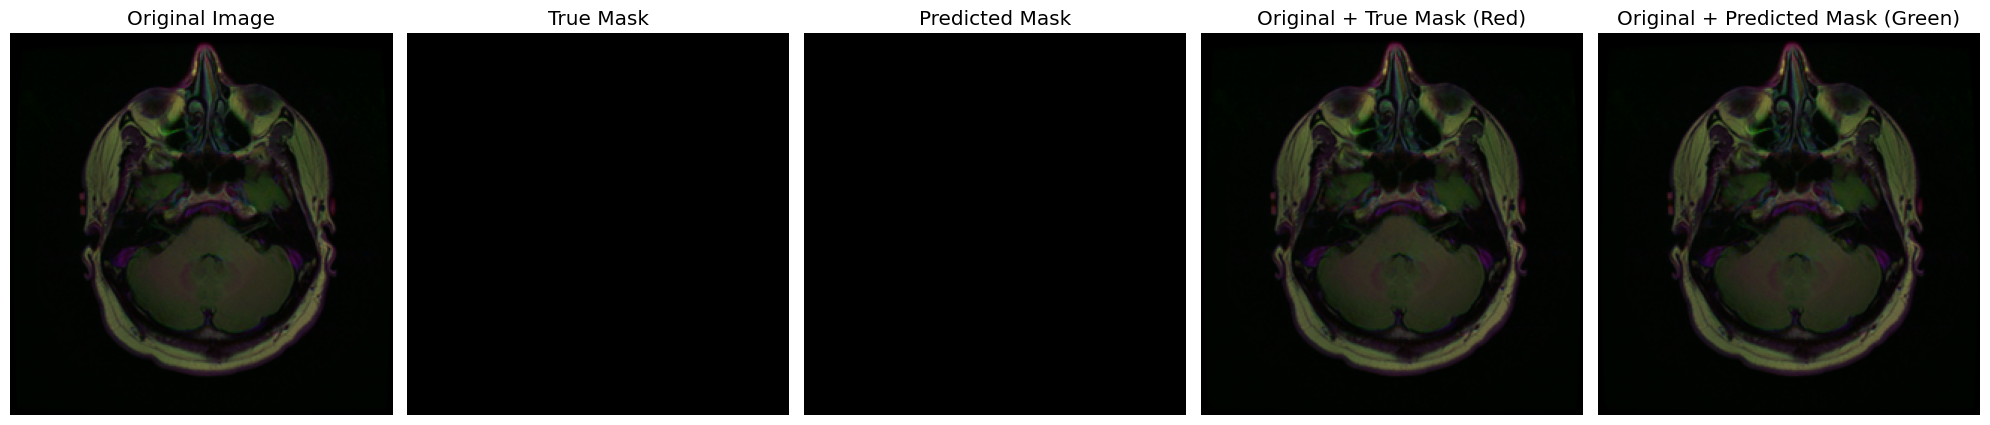

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    image, mask = next(test_generator)
    
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    image_with_true_mask = image[0].copy()  
    image_with_predicted_mask = image[0].copy()  
    # Ajouter le masque réel en rouge
    image_with_true_mask[..., 0] = np.maximum(image_with_true_mask[..., 0], mask[0].squeeze() * 255)  # Rouge

    # Ajouter le masque prédit en vert
    image_with_predicted_mask[..., 1] = np.maximum(image_with_predicted_mask[..., 1], binary_predicted_mask[0].squeeze() * 255)  # Vert
    plt.figure(figsize=(20, 8))

    # Image originale
    plt.subplot(1, 5, 1)
    plt.title("Original Image")
    plt.imshow(image[0])
    plt.axis("off")

    # Masque réel
    plt.subplot(1, 5, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 5, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Image + True Mask
    plt.subplot(1, 5, 4)
    plt.title("Original + True Mask (Red)")
    plt.imshow(image_with_true_mask)
    plt.axis("off")

    # Image + Predicted Mask
    plt.subplot(1, 5, 5)
    plt.title("Original + Predicted Mask (Green)")
    plt.imshow(image_with_predicted_mask)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
